In [47]:
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor, ICLDataPreprocessor
import pickle

import pandas as pd
import numpy as  np
import theano 
import scipy.signal as ss

In [50]:
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT", "AUT"),
    ("Albania", "AL", "ALB"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria", "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia", "EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
    ("Georgia", "GE", "GEO"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("Lithuania", "LT", "LTU"),
    ("Latvia", "LV", "LVA"),
    ("Malta", "MT", "MLT"),
    ("Morocco", "MA", "MAR"),
    ("Mexico", "MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Norway", "NO", "NOR"),
    ("New Zealand", "NZ", "NZL"),
    ("Poland", "PL", "POL"),
    ("Portugal", "PT", "PRT"),
    ("Romania", "RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA", "ZAF"),
]

region_info.sort(key=lambda x: x[0])
region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])
regions_threecode = list([x for _, _, x in region_info])


def eur_to_epi_code(x):
    if x in regions_threecode:
        return regions_epi[regions_threecode.index(x)]
    else:
        return "not found"




def process_euro_data(path, regular_data_path, ICL_data_path):
    
    dp = ICLDataPreprocessor()
    data = dp.preprocess_data(regular_data_path, ICL_data_path)


    
    
    eur_df = pd.read_csv(path, parse_dates=["dateRep"], infer_datetime_format=True)
    eur_df['dateRep'] = pd.to_datetime(eur_df['dateRep'], utc=True)
    epi_codes = [eur_to_epi_code(cc) for cc in eur_df["countryterritoryCode"]]
    dti = pd.to_datetime(eur_df['dateRep'], utc=True)

    eur_df.index = pd.MultiIndex.from_arrays([epi_codes, dti])

    columns_to_drop = ["day", "month", "year", "countriesAndTerritories", "geoId", "popData2018", "continentExp",
                       "dateRep", "countryterritoryCode"]

    for col in columns_to_drop:
        del eur_df[col]

    eur_df = eur_df.loc[regions_epi]

    NewCases = np.zeros((len(data.Rs), len(data.Ds)))
    NewDeaths = np.zeros((len(data.Rs), len(data.Ds)))

    for r_i, r in enumerate(data.Rs):
        for d_i, d in enumerate(data.Ds):
            c_vals = eur_df.loc[r]
            if d in c_vals.index:
                NewCases[r_i, d_i] = c_vals["cases"].loc[d]
                NewDeaths[r_i, d_i] = c_vals["deaths"].loc[d]

    

    SmoothedNewCases = np.around(
        ss.convolve2d(NewCases, 1 / dp.N_smooth * np.ones(shape=(1, dp.N_smooth)), boundary="symm",
                      mode="same"))
    SmoothedNewDeaths = np.around(
        ss.convolve2d(NewDeaths, 1 / dp.N_smooth * np.ones(shape=(1, dp.N_smooth)), boundary="symm",
                      mode="same"))
    
    NewCases = SmoothedNewCases
    NewDeaths = SmoothedNewDeaths
    NewDeaths[NewDeaths < 0] = np.nan
    NewCases[NewCases < 0] = np.nan
    data.NewCases = np.ma.masked_invalid(NewCases.astype(theano.config.floatX))
    data.NewDeaths = np.ma.masked_invalid(NewDeaths.astype(theano.config.floatX))
    
    


    return data

eur_data = process_euro_data("final_data/eur_data.csv", "final_data/data_final.csv", "final_data/ICL.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


In [ ]:
dp = DataPreprocessor()
jh_data = dp.preprocess_data("final_data/data_final.csv")


In [ ]:

jhRs = [ jh_data.Rs.index(r) for r in eur_data.Rs]

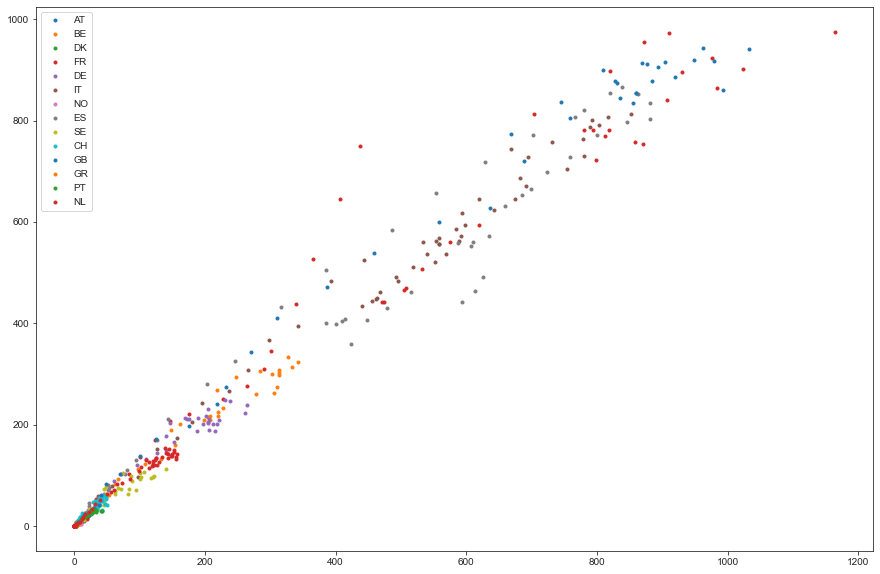

In [69]:
import matplotlib.pylab as plt

plt.figure(figsize=(15,10))

jh  = jh_data.NewDeaths[jhRs[:],:]
eur = eur_data.NewDeaths[:,:]
r = eur_data.Rs[:]

plt.plot(eur.T, jh.T, '.') ;
plt.legend(r)

In [34]:
jh_data.NewCases.shape

(41, 95)

In [35]:
eur_data.NewCases.shape

(14, 95)

In [70]:
eur_data.Rs

['AT',
 'BE',
 'DK',
 'FR',
 'DE',
 'IT',
 'NO',
 'ES',
 'SE',
 'CH',
 'GB',
 'GR',
 'PT',
 'NL']